# 1. Importing Necessary Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import math
import pickle
import os

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from prettytable import PrettyTable
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from datetime import datetime

# 2. Application Train/Test Datasets

In [6]:
# Refer :- https://www.kaggle.com/rinnqd/reduce-memory-usage

def reduce_memory_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## 2.1.  Basic Overview of the Train Data

In [7]:
train_data = pd.read_csv(
    "s3://lakehouse/raw/application_train.csv",
    storage_options={
        "key":    "minio",            # AWS_ACCESS_KEY_ID
        "secret": "minio_admin",      # AWS_SECRET_ACCESS_KEY
        "client_kwargs": {
            "endpoint_url": "http://localhost:9000"
        }
    }
)
print("N rows:", train_data.shape[0])
print("N cols:", train_data.shape[1])

train_data = reduce_memory_usage(train_data)


N rows: 307511
N cols: 122
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [8]:
print('Features : ', train_data.columns.values)

Features :  ['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES

## 2.2. Basic Overview of the Test Data

In [9]:
import pandas as pd

test_data = reduce_memory_usage(
    pd.read_csv(
        "s3://lakehouse/raw/application_test.csv",
        storage_options={
            "key": "minio",                # AWS_ACCESS_KEY_ID của MinIO
            "secret": "minio_admin",       # AWS_SECRET_ACCESS_KEY của MinIO
            "client_kwargs": {
                "endpoint_url": "http://localhost:9000"  # URL MinIO bạn đã expose
            }
        }
    )
)

print("Number of data points : ", test_data.shape[0])
print("Number of features    : ", test_data.shape[1])
test_data.head()

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Number of data points :  48744
Number of features    :  121


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3. Application Train Data Analysis

### 2.3.1. Univariate Analysis : Target

In [10]:
train_data['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [12]:
# Refer :- https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

y_value_counts = train_data['TARGET'].value_counts()
print("Number of customers who will not repay the loan on time: ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of customers who will repay the loan on time: ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
# recipe = ["Will not Repay", "Will Repay"]
#
# data = [y_value_counts[1], y_value_counts[0]]
#
# wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5),\
#                        startangle=-40)
#
# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
#           bbox=bbox_props, zorder=0, va="center")
#
# for i, p in enumerate(wedges):
#     ang = (p.theta2 - p.theta1)/2. + p.theta1
#     y = np.sin(np.deg2rad(ang))
#     x = np.cos(np.deg2rad(ang))
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                  horizontalalignment=horizontalalignment, **kw)
#
# ax.set_title("Number of loans that are repaid and not repaid")
#
# plt.show()

Number of customers who will not repay the loan on time:  24825 , ( 8.072881945686495 %)
Number of customers who will repay the loan on time:  282686 , ( 91.92711805431351 %)


In [17]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])

    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Loans')
    plt.title('Number of loans aproved vs rejected')
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('capable', 'not capable'))
    plt.show()

In [15]:
 def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

    temp.sort_values(by=['total'],inplace=True, ascending=False)

    if top:
        temp = temp[0:top]

    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

### 2.3.2. Univariate Analysis : Name_Contract_Type

In [13]:
train_data['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

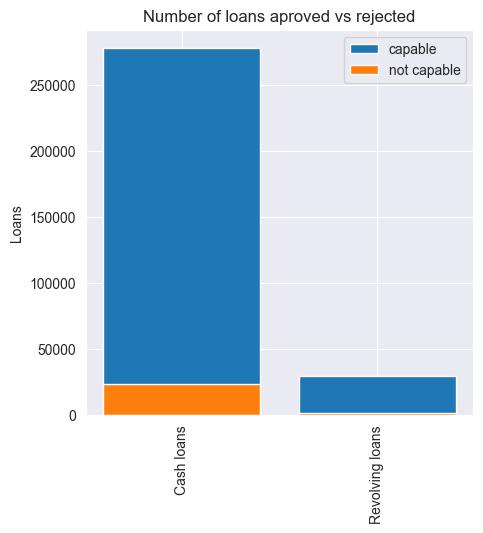

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783
  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [18]:
univariate_barplots(train_data, 'NAME_CONTRACT_TYPE', 'TARGET', False)

**Observations:**
- Most of the people are taking loans in the form of cash loans instead of revolving loans such as credit cards.

### 2.3.3. Univariate Analysis : Code_Gender

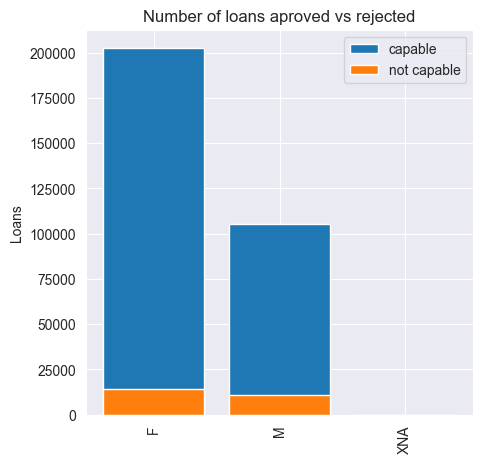

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000
  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [16]:
univariate_barplots(train_data, 'CODE_GENDER', 'TARGET', False)

**Observations:**
- The interesting part over here is the fact that Women took much more number of loans as compared to Men : Whereas Women took a total of 202K+ loans, Men only took 105K+ loans.
- However, at the same time, Men are slightly more capable of repaying the loan as compared to Women. Whereas Men are able to repay their loans in 10% of the cases, Women are only able to repay in 7% of the cases.
- There are 4 entries where Gender='XNA'. Since this is not providing us with much information, we can remove these entries later on.

### 2.3.4. Univariate Analysis : Flag_Own_Car

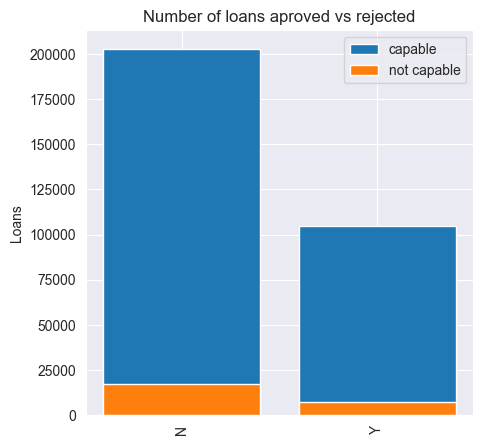

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437
  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [19]:
univariate_barplots(train_data, 'FLAG_OWN_CAR', 'TARGET', False)

**Observations:**
- Most of the applicants for loans do not own a car.
- However, there is not much difference in the loan repayment status for the customer based on this information (8.5% and 7.2% respectively). We can conclude that this feature is not very useful.

### 2.3.5 Univariate Analysis : Flag_Own_Realty

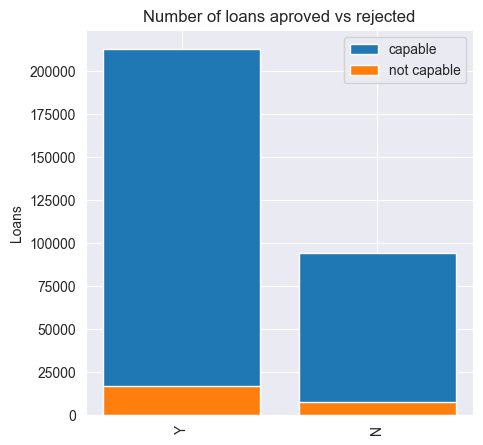

  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249
  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249


In [20]:
univariate_barplots(train_data, 'FLAG_OWN_REALTY', 'TARGET', False)

**Observations:**
- Most of the applicants for loans own a flat/house, which is a little surprising.
- However, again, there is not much difference in the loan repayment status for the customer based on this information (7.9% and 8.3% respectively). We can conclude that this feature is not very useful.

### 2.3.6 Univariate Analysis : Cnt_Children

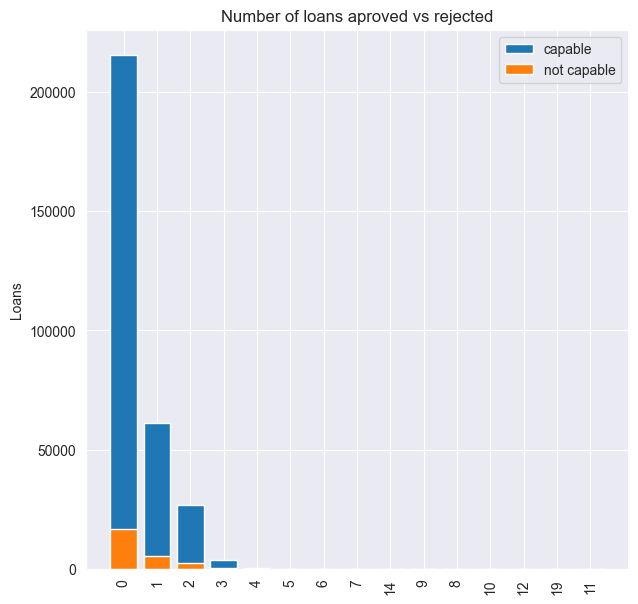

   CNT_CHILDREN  TARGET   total       Avg
0             0   16609  215371  0.077118
1             1    5454   61119  0.089236
2             2    2333   26749  0.087218
3             3     358    3717  0.096314
4             4      55     429  0.128205
    CNT_CHILDREN  TARGET  total  Avg
8              8       0      2  0.0
10            10       0      2  0.0
12            12       0      2  0.0
14            19       0      2  0.0
11            11       1      1  1.0


In [21]:
univariate_barplots(train_data, 'CNT_CHILDREN', 'TARGET', False)

**Observations:**
- The applicants having no children take considerably higher number of loans.
- However, again, there is not much difference in the loan repayment status for the customer based on this information. We can conclude that this feature is not very useful.

### 2.3.7 Univariate Analysis : Amt_Income_Total

In [22]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
income_data = train_data.groupby('SK_ID_CURR').agg({'AMT_INCOME_TOTAL':'mean'}).reset_index()
income_data.head(2)

,SK_ID_CURR,AMT_INCOME_TOTAL
0,100002,202500.0
1,100003,270000.0


In [23]:
income_data_final = pd.merge(train_data, income_data, on='SK_ID_CURR', how='left')

approved_income = income_data_final[income_data_final['TARGET']==0]['AMT_INCOME_TOTAL_x'].values
rejected_income = income_data_final[income_data_final['TARGET']==1]['AMT_INCOME_TOTAL_x'].values

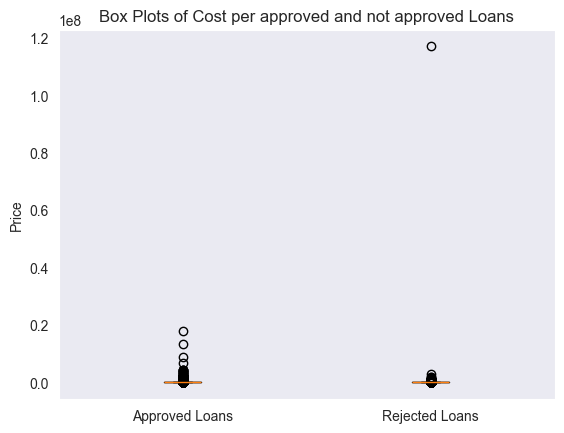

In [24]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_income, rejected_income])
plt.title('Box Plots of Cost per approved and not approved Loans')
plt.xticks([1,2],('Approved Loans','Rejected Loans'))
plt.ylabel('Price')
plt.grid()
plt.show()

In [25]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Loans", "Not Approved Loans"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_income,i), 3),\
               np.round(np.percentile(rejected_income,i), 3)])
print(x)

+------------+----------------+--------------------+
| Percentile | Approved Loans | Not Approved Loans |
+------------+----------------+--------------------+
|     0      |    25650.0     |      25650.0       |
|     5      |    67500.0     |      67500.0       |
|     10     |    81000.0     |      81000.0       |
|     15     |    90000.0     |      90000.0       |
|     20     |    99000.0     |      99000.0       |
|     25     |    112500.0    |      112500.0      |
|     30     |    112500.0    |      112500.0      |
|     35     |    126000.0    |      120873.2      |
|     40     |    135000.0    |      135000.0      |
|     45     |    135000.0    |      135000.0      |
|     50     |    148500.0    |      135000.0      |
|     55     |    157500.0    |      157500.0      |
|     60     |    166500.0    |      157500.0      |
|     65     |    180000.0    |      175500.0      |
|     70     |    185400.0    |      180000.0      |
|     75     |    202500.0    |      202500.0 

**Kết luận rút ra:**
- Tại các percentiles thấp (dưới khoảng 45%), thu nhập của hai nhóm khá tương đương.
- Ở các percentiles cao hơn, thu nhập càng lớn thì tỷ lệ được duyệt khoản vay càng cao.

### 2.3.8. Univariate Analysis : Amt_Credit

In [ ]:
for i in train_data.groupby('SK_ID_CURR',as_index=False).size():
    if i>1:
        print(i)
#This means that each row in the train_data has a unique SK_ID_CURR

In [27]:
train_data[train_data['SK_ID_CURR']==100002]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
approved_loan_credit = train_data[train_data['TARGET']==0]['AMT_CREDIT'].values
rejected_loan_credit = train_data[train_data['TARGET']==1]['AMT_CREDIT'].values

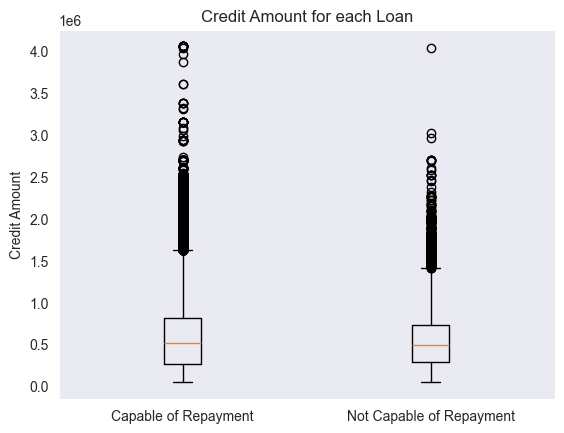

In [29]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_loan_credit, rejected_loan_credit])
plt.title('Credit Amount for each Loan')
plt.xticks([1,2],('Capable of Repayment','Not Capable of Repayment'))
plt.ylabel('Credit Amount')
plt.grid()
plt.show()

**Kết luận rút ra:**
- Khoảng giá trị vay chủ yếu tập trung ở mức trung bình → không quá rộng.
- Nhóm vay với số tiền lớn hơn trung bình có xu hướng trả được nợ cao hơn nhóm vay ít.
- Tuy hiệu quả không quá mạnh, nhưng biến AMT_CREDIT vẫn mang thông tin phân biệt nhẹ giữa hai nhóm, có thể được đưa vào model như một feature đơn giản nhưng hữu ích.

### 2.3.9 Univariate Analysis : Amt_Annuity

In [36]:
# Số tiền phải trả hàng kỳ của khoản vay
capable_loan_annuity = train_data[train_data['TARGET']==0]['AMT_ANNUITY'].values
not_capable_loan_annuity = train_data[train_data['TARGET']==1]['AMT_ANNUITY'].values

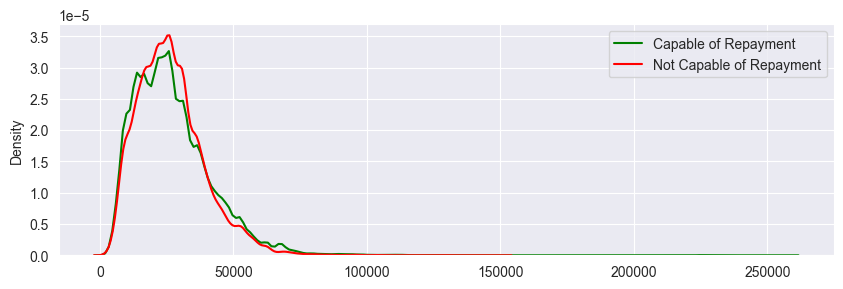

In [31]:
plt.figure(figsize=(10,3))
sns.distplot(capable_loan_annuity,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_annuity,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
- Hầu hết các khoản annuity đều nằm dưới khoảng 50.000 (đơn vị tiền), tức phần lớn khách hàng có giá trị thanh toán kỳ hạn không quá cao.
- Nếu hai đường mật độ của hai nhóm gần như chồng lên nhau thì biến này ít phân biệt được hai lớp, nhưng nếu nhóm không trả được có xu hướng tập trung quanh giá thấp hoặc có đuôi dài khác biệt thì AMT_ANNUITY vẫn có thể mang tín hiệu dự báo.

### 2.3.10 Univariate Analysis : Amt_Goods_Price

In [37]:
capable_loan_goods_price = train_data[train_data['TARGET']==0]['AMT_GOODS_PRICE'].values
not_capable_loan_goods_price = train_data[train_data['TARGET']==1]['AMT_GOODS_PRICE'].values

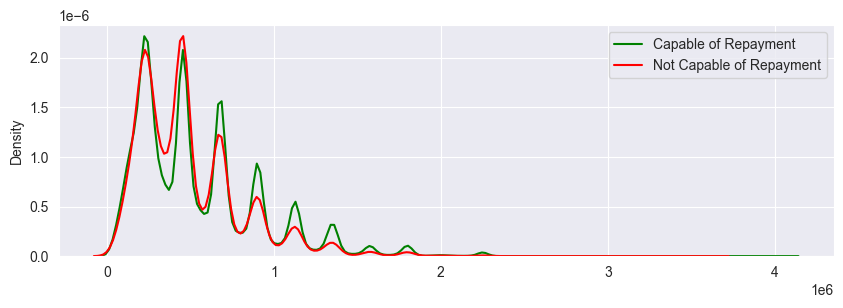

In [33]:
plt.figure(figsize=(10,3))
sns.distplot(capable_loan_goods_price,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_goods_price,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Phần lớn các khoản vay tập trung vào món hàng có giá dưới 1.000.000 (tương đương 10 lakhs).
* Nếu đường cong của hai nhóm lệch nhau ở các mức giá cao hoặc thấp, nghĩa là giá trị món hàng cũng có thể ảnh hưởng đến khả năng trả nợ. Ở đây, do cả hai curve tương đối chồng gần lên nhau, biến này có thể không phân biệt quá mạnh giữa hai nhóm—nhưng vẫn đáng đưa vào thử nghiệm trong mô hình.

### 2.3.11 Univariate Analysis : Name_Type_Suite

In [38]:
train_data['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

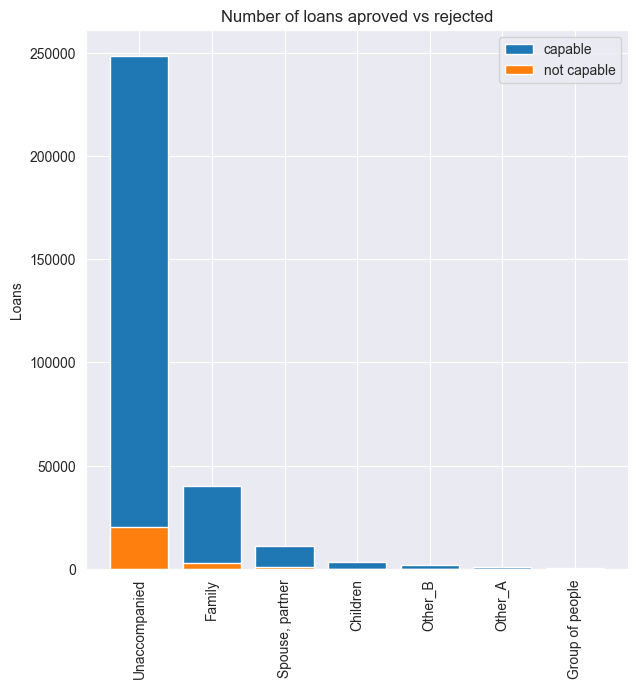

   NAME_TYPE_SUITE  TARGET   total       Avg
6    Unaccompanied   20337  248526  0.081830
1           Family    3009   40149  0.074946
5  Spouse, partner     895   11370  0.078716
0         Children     241    3267  0.073768
4          Other_B     174    1770  0.098305
   NAME_TYPE_SUITE  TARGET  total       Avg
5  Spouse, partner     895  11370  0.078716
0         Children     241   3267  0.073768
4          Other_B     174   1770  0.098305
3          Other_A      76    866  0.087760
2  Group of people      23    271  0.084871


In [39]:
univariate_barplots(train_data, 'NAME_TYPE_SUITE', 'TARGET', False)